## Ocean Sea Breeze EDA and Occupancy Time Series forecast

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import itertools
plt.style.use('fivethirtyeight') 

%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from fbprophet import Prophet
import math
from sklearn.metrics import mean_squared_error
from random import random
from math import sqrt

In [3]:
sbz = pd.read_excel("concat_raw_sbz.xlsx")

In [9]:
sbz[['DATE', 'DAY_OF_WEEK']] = sbz['DATE'].str.split(' ', n=1, expand=True)
sbz['DATE'] = pd.to_datetime(sbz['DATE'])
sbz = sbz.sort_values('DATE')

print('Time period start: {}\nTime period end: {}'.format(sbz.DATE.min(),sbz.DATE.max()))

Time period start: 2016-01-01 00:00:00
Time period end: 2019-06-30 00:00:00


In [13]:
sbz.set_index('DATE', inplace=True)
sbz = sbz.loc[~sbz.index.duplicated(keep='first')]

## Occupancy, Revenue and Average rate distribution

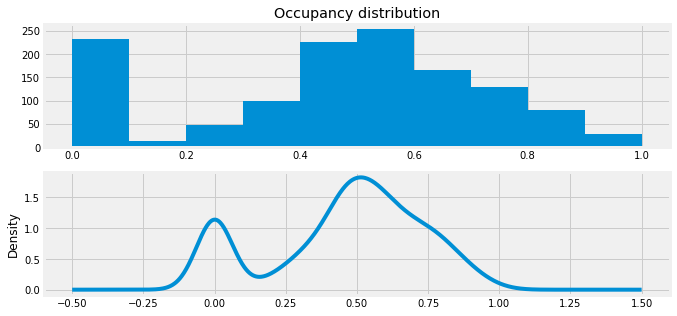

In [15]:
plt.figure(1)
plt.subplot(211)
sbz['OCC %'].hist(figsize=(10,5))
plt.title('Occupancy distribution')
plt.subplot(212)
sbz['OCC %'].plot(kind='kde')
plt.show();

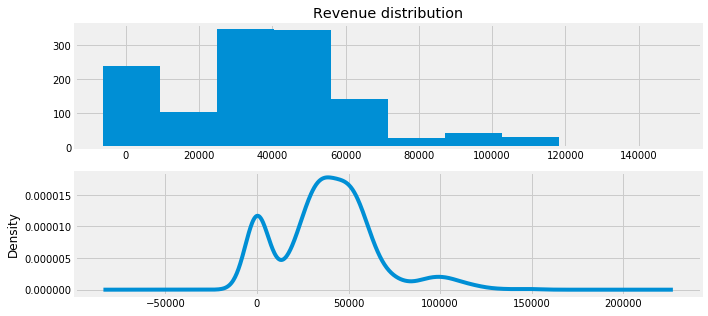

In [19]:
plt.figure(1)
plt.subplot(211)
sbz['REVENUE'].hist(figsize=(10,5))
plt.title('Revenue distribution')
plt.subplot(212)
sbz['REVENUE'].plot(kind='kde')
plt.show();

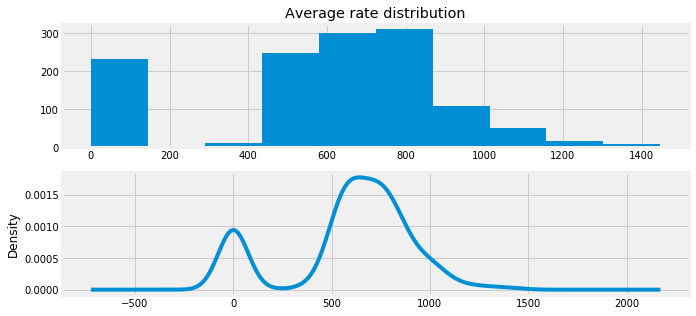

In [20]:
plt.figure(1)
plt.subplot(211)
sbz['AVE RATE'].hist(figsize=(10,5))
plt.title('Average rate distribution')
plt.subplot(212)
sbz['AVE RATE'].plot(kind='kde')
plt.show();

It looks like a bimodal distribution. And it turns out, there were 230 days in 2017 with occupancy at zero. Seems the hotel was closed for 6.5 months for renovation.

In [21]:
sbz.loc[sbz['OCC %'] == 0]

,IND REV,IND RM,GROUP REV,GROUP RM,ALLOT REV,ALLOT RM,REVENUE,RM OCC,AVE RATE,OCC %,DAY_OF_WEEK
DATE,,,,,,,,,,,
2017-04-30,0.00,0,0.0,0,0.0,0,0.00,0,0.0,0.0,Sun
2017-05-01,0.00,0,0.0,0,0.0,0,0.00,0,0.0,0.0,Mon
2017-05-02,0.00,0,0.0,0,0.0,0,0.00,0,0.0,0.0,Tue
2017-05-03,-6095.23,0,0.0,0,0.0,0,-6095.23,0,0.0,0.0,Wed
2017-05-04,2638.10,0,0.0,0,0.0,0,2638.10,0,0.0,0.0,Thu
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-11,0.00,0,0.0,0,0.0,0,0.00,0,0.0,0.0,Mon
2017-12-12,0.00,0,0.0,0,0.0,0,0.00,0,0.0,0.0,Tue
2017-12-13,-0.04,0,0.0,0,0.0,0,-0.04,0,0.0,0.0,Wed


## Boxplot

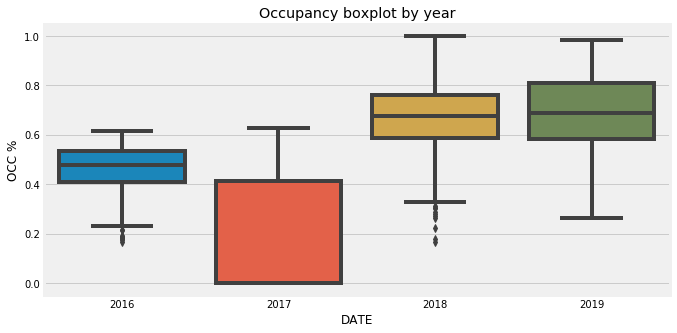

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz.index.year, sbz['OCC %'], ax=ax)
plt.title('Occupancy boxplot by year');

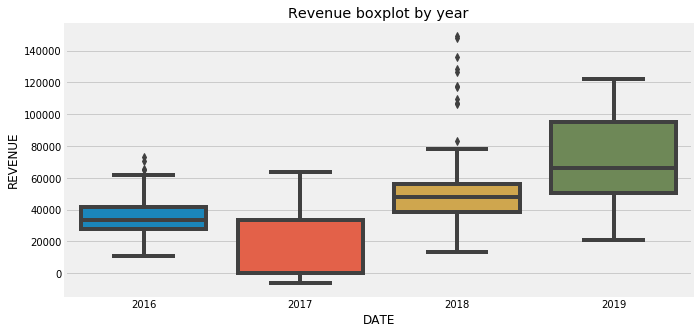

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz.index.year, sbz['REVENUE'], ax=ax)
plt.title('Revenue boxplot by year');

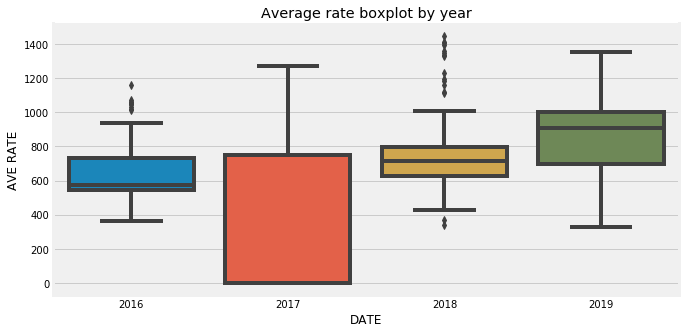

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz.index.year, sbz['AVE RATE'], ax=ax)
plt.title('Average rate boxplot by year');

The 6.5 months closure made 2017 look bad.

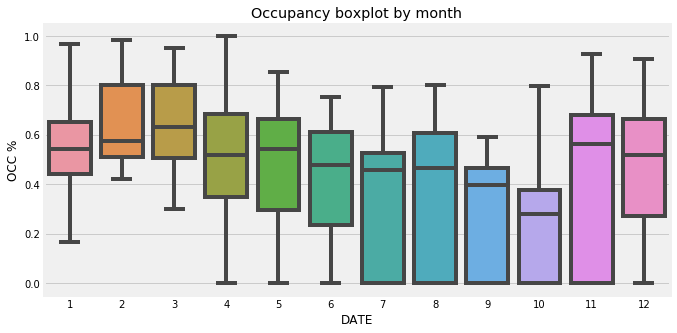

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz.index.month, sbz['OCC %'], ax=ax)
plt.title('Occupancy boxplot by month');

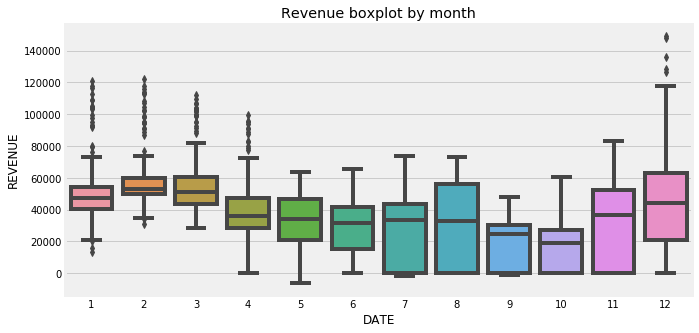

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz.index.month, sbz['REVENUE'], ax=ax)
plt.title('Revenue boxplot by month');

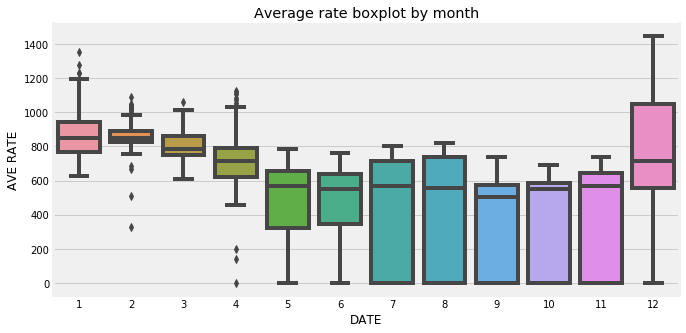

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz.index.month, sbz['AVE RATE'], ax=ax)
plt.title('Average rate boxplot by month');

The closure definitely affected monthly performance for 6 months.

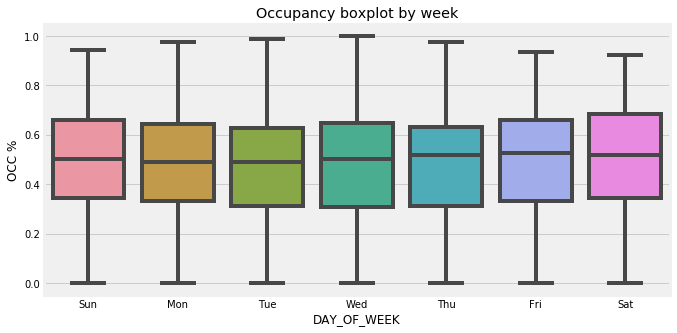

In [28]:
order = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz['DAY_OF_WEEK'], sbz['OCC %'], ax=ax, order=order)
plt.title('Occupancy boxplot by week');

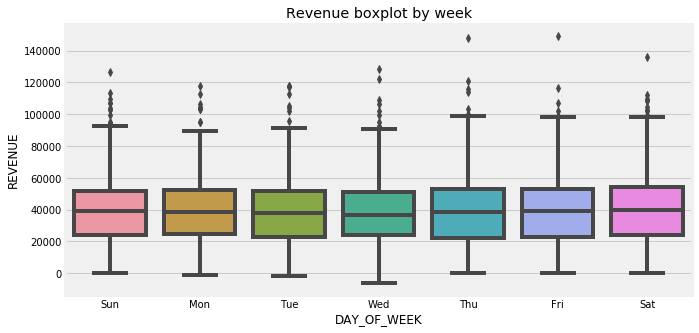

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz['DAY_OF_WEEK'], sbz['REVENUE'], ax=ax, order=order)
plt.title('Revenue boxplot by week');

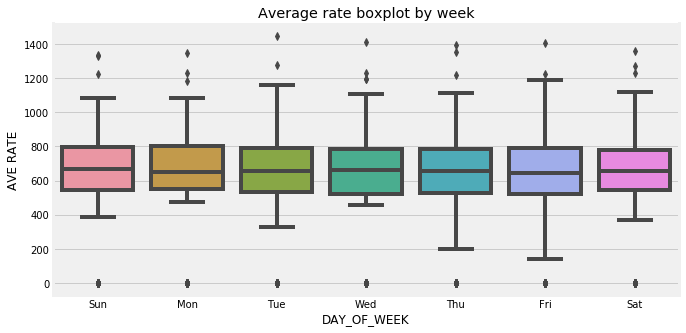

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(sbz['DAY_OF_WEEK'], sbz['AVE RATE'], ax=ax, order=order)
plt.title('Average rate boxplot by week');

There was no significant difference for median occupancy, revenue and daily rate between day of week, or weekday vs. weekend.

### Time Series

#### At this time, we care about occupancy, revenue and average rate, let's focus on them.

The following three plots show occupancy, revenue and average rate trends from 2016 to June 2019. except those 6.5 months, they do reveal somewhat upward trend, with seasonality.

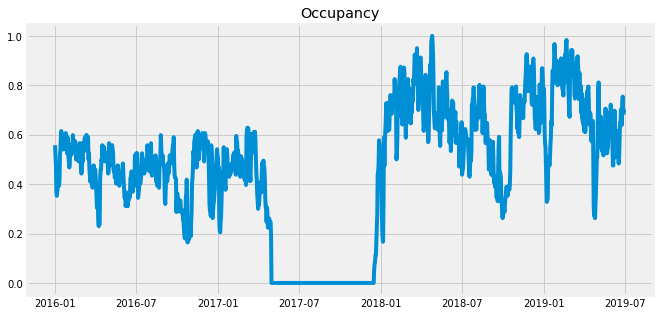

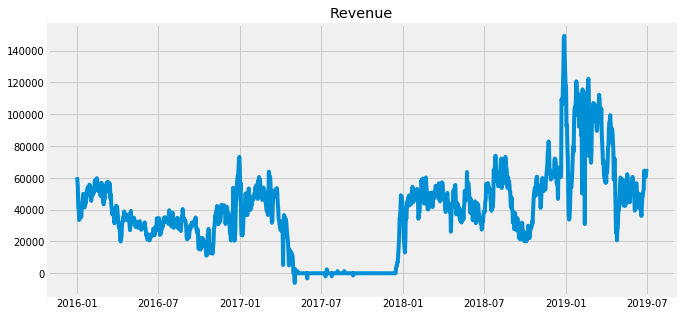

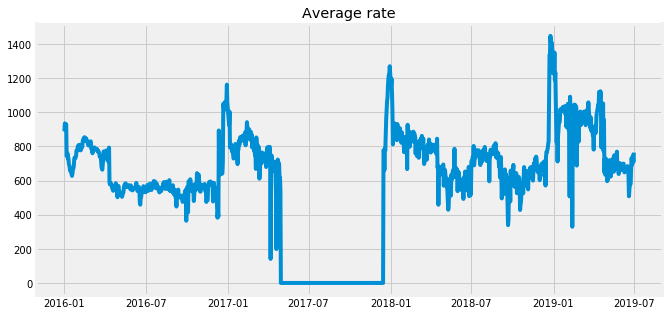

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(sbz['OCC %'])
plt.title('Occupancy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sbz['REVENUE'])
plt.title('Revenue')
plt.grid(True)
plt.show();

plt.figure(figsize=(10, 5))
plt.plot(sbz['AVE RATE'])
plt.title('Average rate')
plt.grid(True)
plt.show();

We can see that the peak season is around December and January, and off-peak season is around September and October.

### Shifting and lags on occupancy, revenue and average rate

We can shift index by let's say 10 months periods with a month frequency. So that we can compare the time series with a past of itself.

In [32]:
pd.plotting.register_matplotlib_converters()

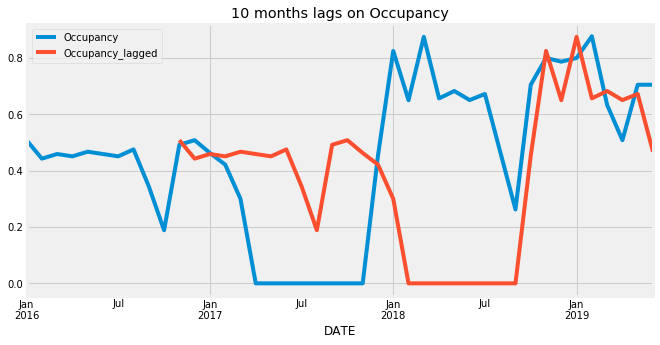

In [33]:
sbz["OCC %"].asfreq('M').plot(legend=True, figsize=(10, 5))
shifted = sbz["OCC %"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Occupancy','Occupancy_lagged'])
plt.title('10 months lags on Occupancy')
plt.show();

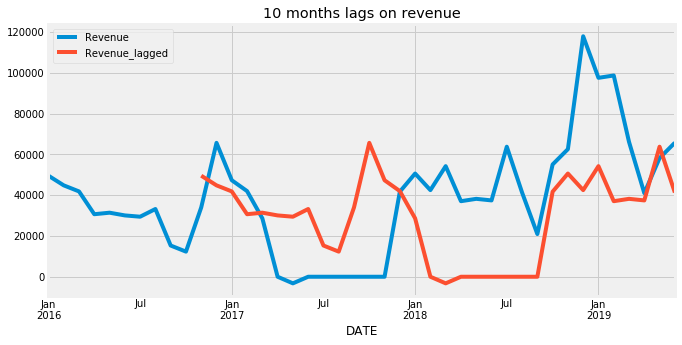

In [34]:
sbz["REVENUE"].asfreq('M').plot(legend=True, figsize=(10, 5))
shifted = sbz["REVENUE"].asfreq('M').shift(10).plot(legend=True, figsize=(10,5))
shifted.legend(['Revenue','Revenue_lagged'])
plt.title('10 months lags on revenue')
plt.show();

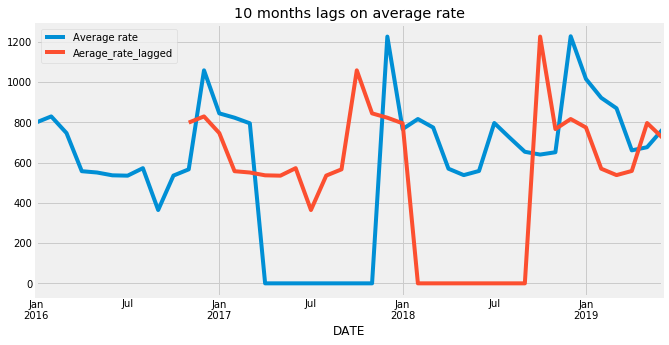

In [35]:
sbz["AVE RATE"].asfreq('M').plot(legend=True, figsize=(10,5))
shifted = sbz["AVE RATE"].asfreq('M').shift(10).plot(legend=True, figsize=(10,5))
shifted.legend(['Average rate','Aerage_rate_lagged'])
plt.title('10 months lags on average rate')
plt.show();

### Percent change on Occupancy

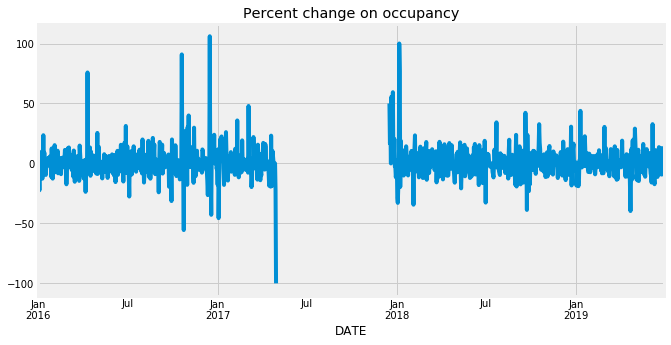

In [36]:
sbz['OCC %'].pct_change().mul(100).plot(figsize=(10,5))
plt.title('Percent change on occupancy');

### Moving average

The purpose of using moving average is that when we analyze time series data, we want to smooth out short-term fluctuations and highlight longer-term trends or cycles. The parameters of the moving average shall be set accordingly, and I set 30 days here.

We plot a rolling mean of 30 day window with the occupancy.

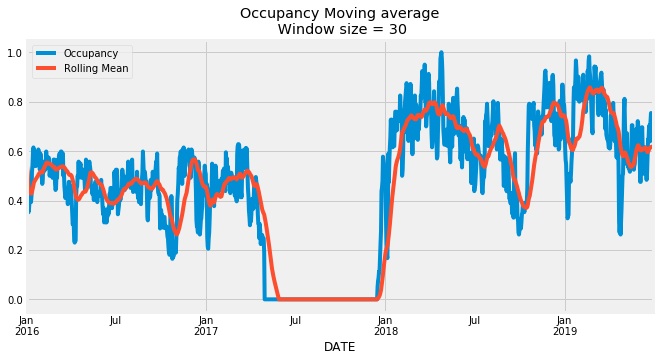

In [37]:
rolling_occ = sbz['OCC %'].rolling('30D').mean()
sbz['OCC %'].plot(figsize=(10,5))
rolling_occ.plot(figsize=(10,5))
plt.legend(['Occupancy','Rolling Mean'])
plt.title('Occupancy Moving average\n Window size = 30')
plt.show();

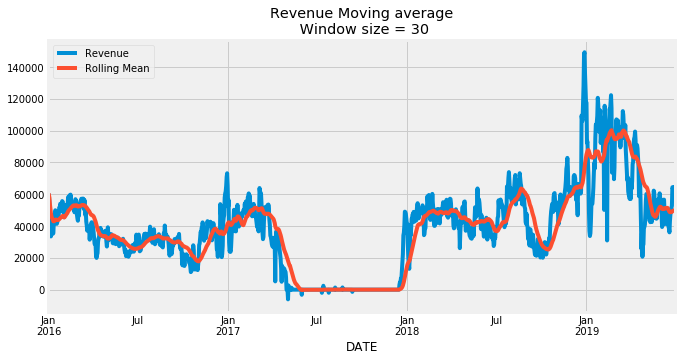

In [38]:
rolling_rev = sbz['REVENUE'].rolling('30D').mean()
sbz['REVENUE'].plot(figsize=(10,5))
rolling_rev.plot(figsize=(10,5))
plt.legend(['Revenue','Rolling Mean'])
plt.title('Revenue Moving average\n Window size = 30')
plt.show();

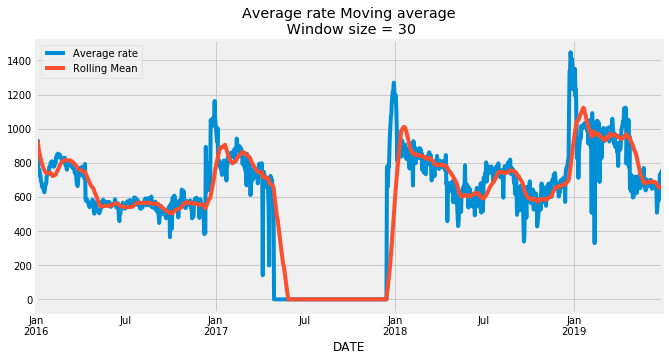

In [39]:
rolling_ave = sbz['AVE RATE'].rolling('30D').mean()
sbz['AVE RATE'].plot(figsize=(10,5))
rolling_ave.plot(figsize=(10,5))
plt.legend(['Average rate','Rolling Mean'])
plt.title('Average rate Moving average\n Window size = 30')
plt.show();

## Time series trend and seasonality

We use decomposition as a primary tool for time series analysis, because it provides a structured way of thinking about a time series forecasting problem. As you can see, each of the following components are something we may need to think about and address during the analysis.

### Occupancy

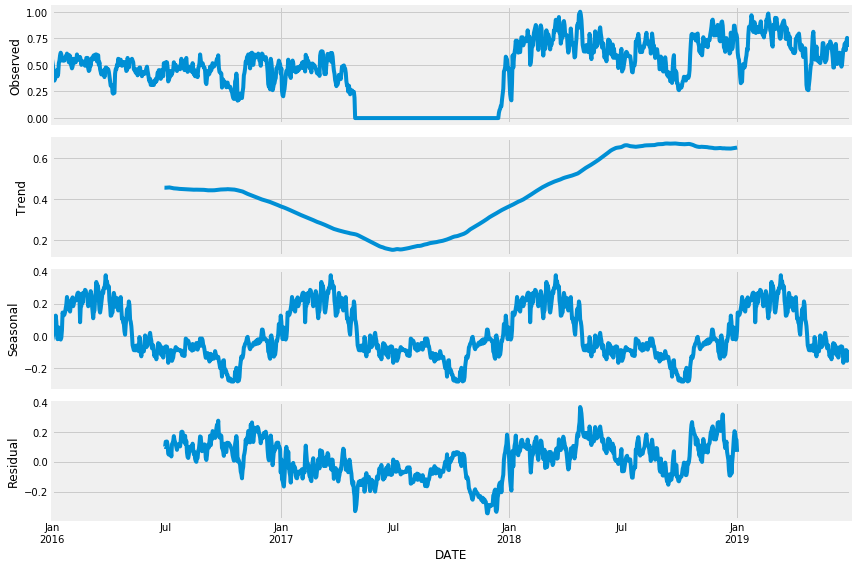

In [40]:
rcParams['figure.figsize'] = 12, 8
decomposed_occ = sm.tsa.seasonal_decompose(sbz["OCC %"], model='additive', freq=360) # The frequncy is annual
figure = decomposed_occ.plot()
plt.show();

Observations:

* During the past three years, except those 6.5 months in 2017, the hotel experienced its lowest occupancy around Oct 2016. Started from January 2018, the hotel showed a consistent upward trend until July 2018, and has been steady since then.
* There are uniform seasonal changes, such as occupancy is always low around October, and occupancy is always high around February and March.
* Residual represents outliers and missing values. It is showing periods of high variability around May 2017, the end of 2017 and around May 2018.

### Revenue

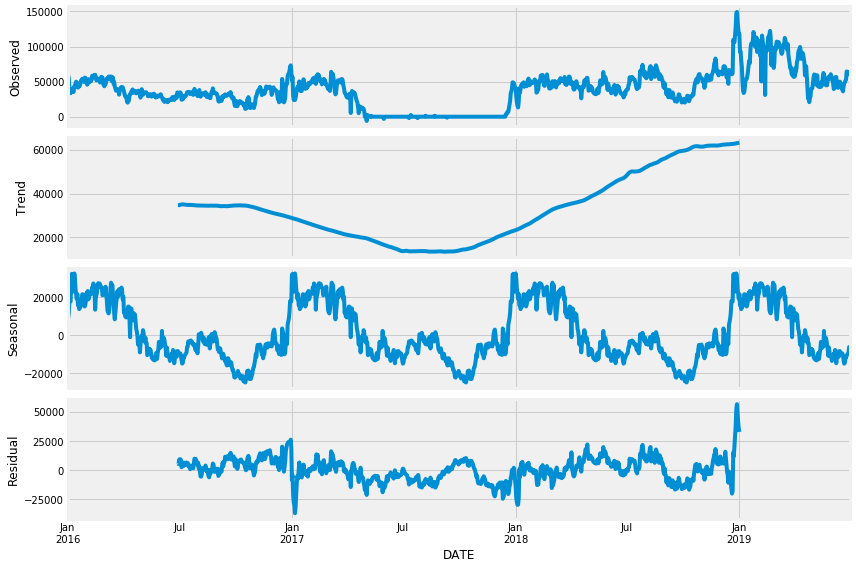

In [41]:
rcParams['figure.figsize'] = 12, 8
decomposed_rev = sm.tsa.seasonal_decompose(sbz['REVENUE'], model='additive', freq=360)
figure = decomposed_rev.plot()
plt.show();

Observations:

* Similar with occupancy, we observed a consisitent upward trend in revenue since early 2018, and has been flatten in the recent months. 
* The seasonality and residual in revenue are obvious too.

### Avereage daily rate

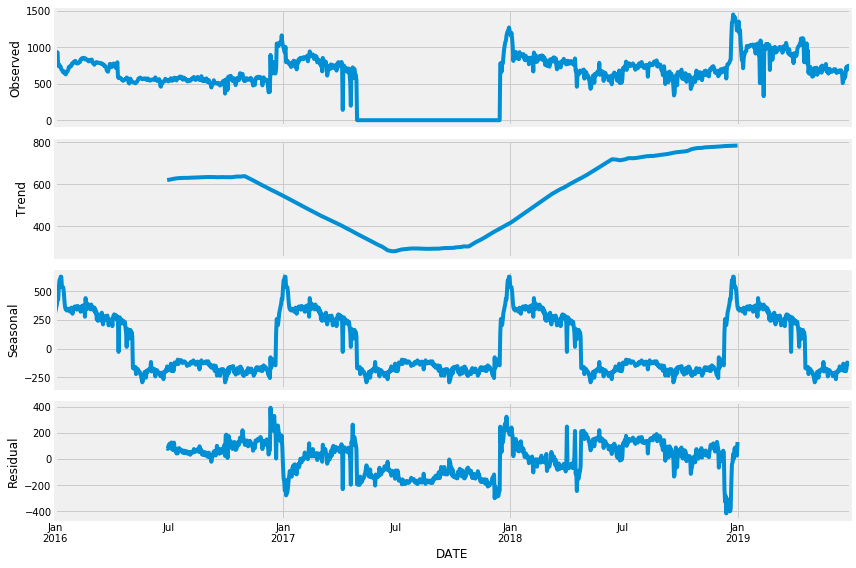

In [42]:
rcParams['figure.figsize'] = 12, 8
decomposed_ave = sm.tsa.seasonal_decompose(sbz['AVE RATE'], model='additive', freq=360)
figure = decomposed_ave.plot()
plt.show();

The average daily rate is showing a consistent growth as well started from early 2018.

### Quarterly

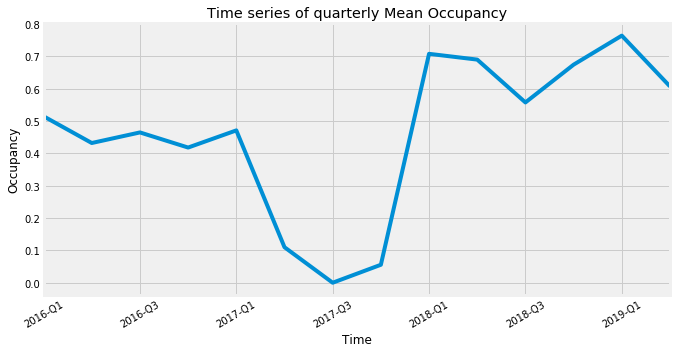

In [44]:
sbz.reset_index(level=0, inplace=True)
sbz['year'] = sbz['DATE'].dt.year
sbz['month'] = sbz['DATE'].dt.month
month_quarter_map = {1: 'Q1', 2: 'Q1', 3: 'Q1',
                     4: 'Q2', 5: 'Q2', 6: 'Q2',
                     7: 'Q3', 8: 'Q3', 9: 'Q3',
                     10: 'Q4', 11: 'Q4', 12: 'Q4'
                    }
sbz['quarter'] = sbz['month'].map(lambda m: month_quarter_map.get(m))
seasonal_sub_series_data = sbz.groupby(by=['year', 'quarter'])['OCC %', 'REVENUE', 'AVE RATE'].aggregate([np.mean])
seasonal_sub_series_data.columns = ['quarterly_mean_occ', 'quarterly_mean_rev', 'quarterly_mean_ave']
seasonal_sub_series_data.reset_index(inplace=True)
seasonal_sub_series_data.index = seasonal_sub_series_data['year'].astype(str) + '-' + seasonal_sub_series_data['quarter']

plt.figure(figsize=(10, 5))
seasonal_sub_series_data['quarterly_mean_occ'].plot()
plt.title('Time series of quarterly Mean Occupancy')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.xticks(rotation=30);

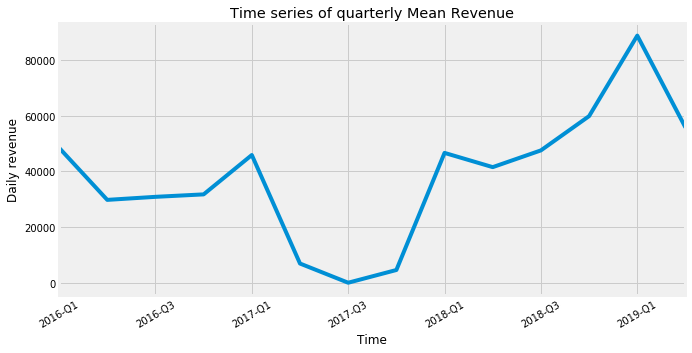

In [45]:
plt.figure(figsize=(10, 5))
seasonal_sub_series_data['quarterly_mean_rev'].plot()
plt.title('Time series of quarterly Mean Revenue')
plt.xlabel('Time')
plt.ylabel('Daily revenue')
plt.xticks(rotation=30);

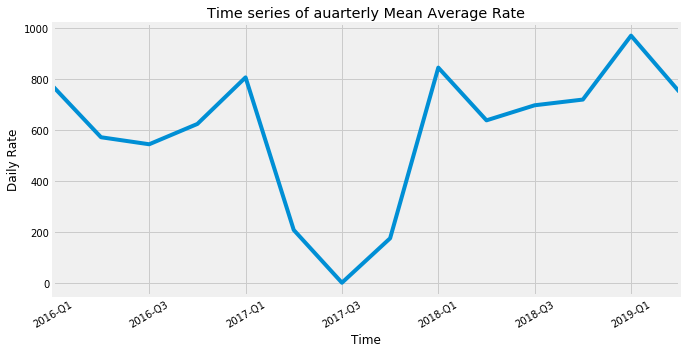

In [46]:
plt.figure(figsize=(10, 5))
seasonal_sub_series_data['quarterly_mean_ave'].plot()
plt.title('Time series of auarterly Mean Average Rate')
plt.xlabel('Time')
plt.ylabel('Daily Rate')
plt.xticks(rotation=30);

For the past three years, the best quarter was Q1 2019, for everything. The worst, of course, it was from May to December 2017 when the hotel had no occuppancy, that time period crossed almost three quarters.

### Monthly

The monthly aggregates occupancy, revenue and average rate are plotted in the following figures, which highlights the month wise seasonality.

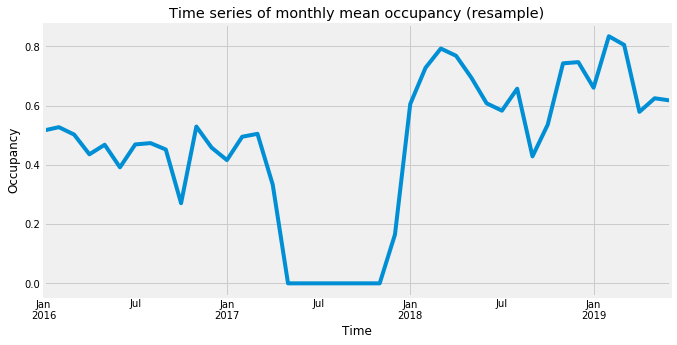

In [48]:
sbz.set_index('DATE', inplace=True)
data_columns = sbz.columns

plt.figure(figsize=(10, 5))
monthly_mean = sbz[data_columns].resample('M').mean()
monthly_mean['OCC %'].plot()
plt.title('Time series of monthly mean occupancy (resample)')
plt.xlabel('Time')
plt.ylabel('Occupancy');

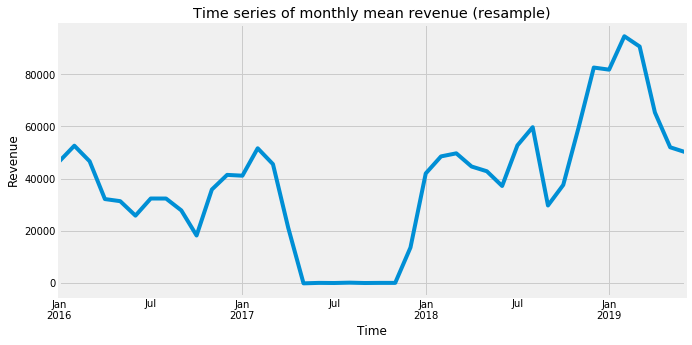

In [49]:
plt.figure(figsize=(10, 5))
monthly_mean['REVENUE'].plot()
plt.title('Time series of monthly mean revenue (resample)')
plt.xlabel('Time')
plt.ylabel('Revenue');

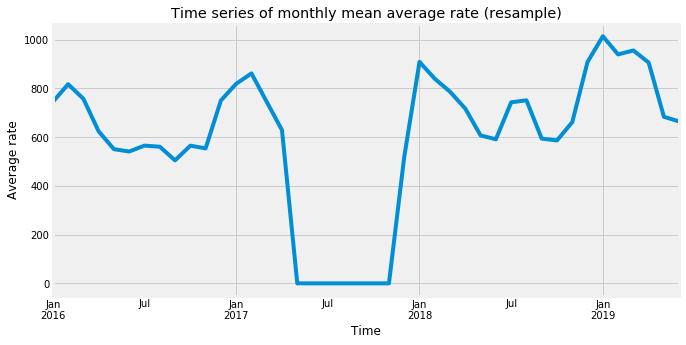

In [50]:
plt.figure(figsize=(10, 5))
monthly_mean['AVE RATE'].plot()
plt.title('Time series of monthly mean average rate (resample)')
plt.xlabel('Time')
plt.ylabel('Average rate');

Observations:

* Except May to December 2017, we can reveal that Around September and October are the slow months for the hotel.

* Earlier part of the year, such as around February and March are the peak months for the hotel.

* The best month for the past three years was around February 2019, the hotel achieved the highest occupancy and revenue.

* The hotel achieved the highest daily average rate in January 2019.

### Weekly

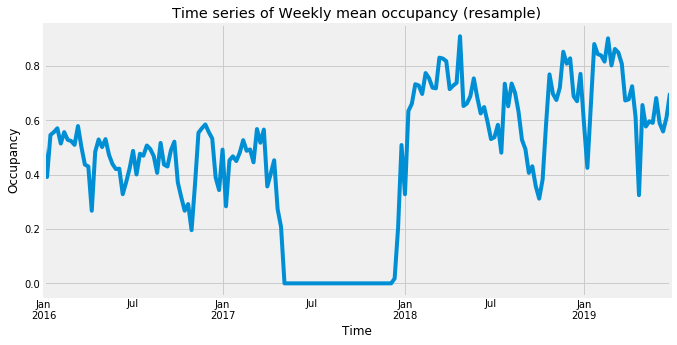

In [53]:
# Resample to weekly frequency, aggregating with mean
weekly_mean = sbz[data_columns].resample('W').mean()
plt.figure(figsize=(10, 5))
weekly_mean['OCC %'].plot()
plt.title('Time series of Weekly mean occupancy (resample)')
plt.xlabel('Time')
plt.ylabel('Occupancy');

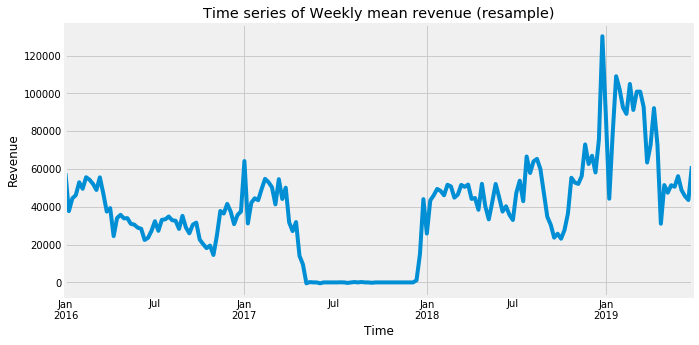

In [54]:
plt.figure(figsize=(10, 5))
weekly_mean['REVENUE'].plot()
plt.title('Time series of Weekly mean revenue (resample)')
plt.xlabel('Time')
plt.ylabel('Revenue');

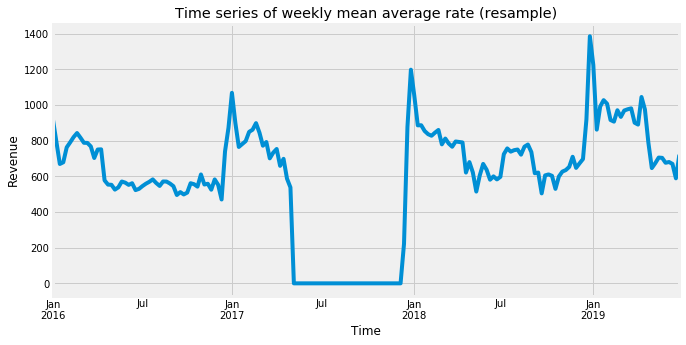

In [55]:
plt.figure(figsize=(10, 5))
weekly_mean['AVE RATE'].plot()
plt.title('Time series of weekly mean average rate (resample)')
plt.xlabel('Time')
plt.ylabel('Revenue');

We can see that the weekly mean time series is smoother than the daily time series, and monthly mean time series is smoother than the weekly time series, and quarterly mean time series is smoother than the monthly time series. Because higher frequency variability has been averaged out in the resampling.

### Pivot table

Using pivot table to analyze and compare by year.

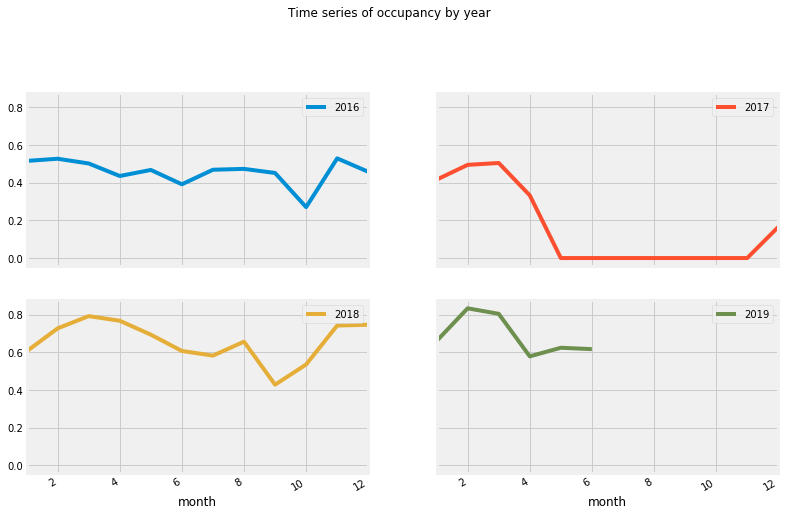

In [56]:
sbz_pivot = pd.pivot_table(sbz, values = "OCC %", columns = "year", index = "month")
sbz_pivot.plot(subplots = True, figsize=(12, 12), layout=(3, 2), sharey=True, title ='Time series of occupancy by year');

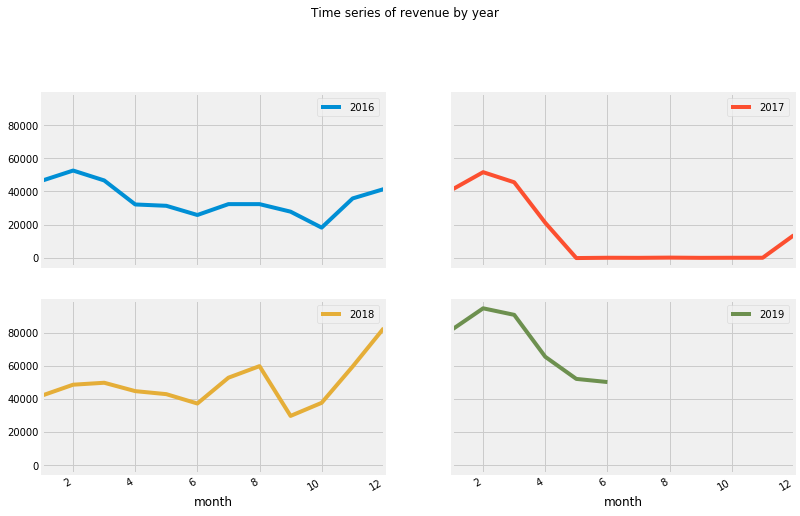

In [57]:
sbz_pivot1 = pd.pivot_table(sbz, values = "REVENUE", columns = "year", index = "month")
sbz_pivot1.plot(subplots = True, figsize=(12, 12), layout=(3, 2), sharey=True, title ='Time series of revenue by year');

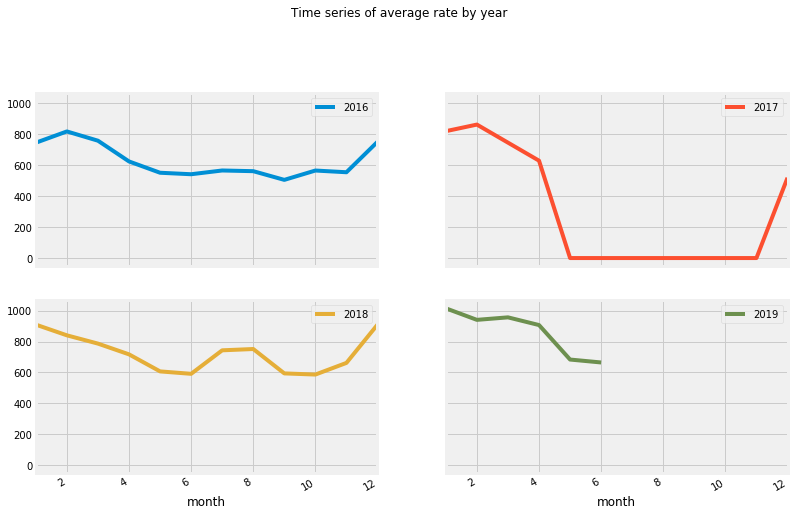

In [58]:
sbz_pivot2 = pd.pivot_table(sbz, values = "AVE RATE", columns = "year", index = "month")
sbz_pivot2.plot(subplots = True, figsize=(12, 12), layout=(3, 2), sharey=True, title ='Time series of average rate by year');

I believe that once the hotel is fully operational, the business follows the similar trend and pattern year over year.

### Autocorrelation and partial autocorrelation

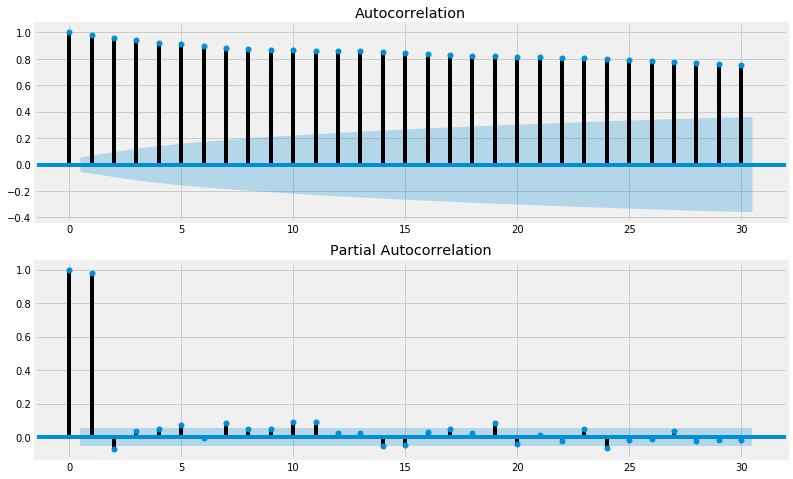

In [59]:
plt.figure()
plt.subplot(211)
plot_acf(sbz['OCC %'], ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(sbz['OCC %'], ax=plt.gca(), lags = 30)
plt.show();

* If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
* Autocorrelation plot shows most of the lags are either close to 1 or at least greater than the confidence interval, they seem to be statistically significant (stationary).
* Partial autocorrelation after first 2 lags is very low, and only a few lags seem to be statistically significant.
* The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Augmented Dickey-Fuller Test

* In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. A unit root is a feature of random walks that can cause problems in statistical inference involving time series models.
* The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
* Null hypothesis: The time series is not stationary.
* Rejecting the null hypothesis (i.e. a very low p-value) will indicate stationarity.

In [60]:
#Perform Dickey-Fuller test on occupancy:
print ('Results of Dickey-Fuller Test on occupancy:')
dftest = adfuller(sbz['OCC %'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test on occupancy:
Test Statistic                   -1.884052
p-value                           0.339600
#Lags Used                       23.000000
Number of Observations Used    1253.000000
Critical Value (1%)              -3.435580
Critical Value (5%)              -2.863849
Critical Value (10%)             -2.568000
dtype: float64


### Predicting and forecasting Occupancy using ARIMA model

In [61]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [63]:
# sbz.set_index('DATE', inplace=True)
y = sbz['OCC %'].resample('MS').mean()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:65.60667508366748
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1161.0590878285702
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:32.59208602638398
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:33.480526363914876
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:23.227754756076568
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11.480594235921835


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:21.824152244943647
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1301.6416544986294
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:9.278086123244158
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:7.3077932048226115
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5.178288284402239
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1.15101107025267
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-44.597103315560275
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1236.6553921824734
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-8.241289669926818


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-25.91200611294579
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1339.5349412392736
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-17.576684035431374
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-41.16249561605803


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1150.9757161319235
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-5.071419002333302
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-27.312605777995564
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1162.7398108486402
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-19.827867456213216
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-45.243686777798395
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1254.5768390974479
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-9.286578298843471
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-24.129464150194803


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-21.875746278142632
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-15.712843679814654
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-41.98327905080897
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1303.641654498665
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-6.65687149728069
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-25.7740680576945
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-22.316877034172094
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-18.54779145303952
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-43.13047336586659
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1267.205954278063
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-6.334620802150299


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-24.555188678309904
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1279.3315524081831


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-15.689145981678834
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-41.4162399881424
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1254.8796257072715


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-4.969580053378284
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-24.323751235860776


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1266.6436062110795
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-13.601000894376941


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [76]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7774      0.146     -5.330      0.000      -1.063      -0.492
ma.L1          1.0000   1410.552      0.001      0.999   -2763.631    2765.631
sigma2         0.0161     22.660      0.001      0.999     -44.397      44.429


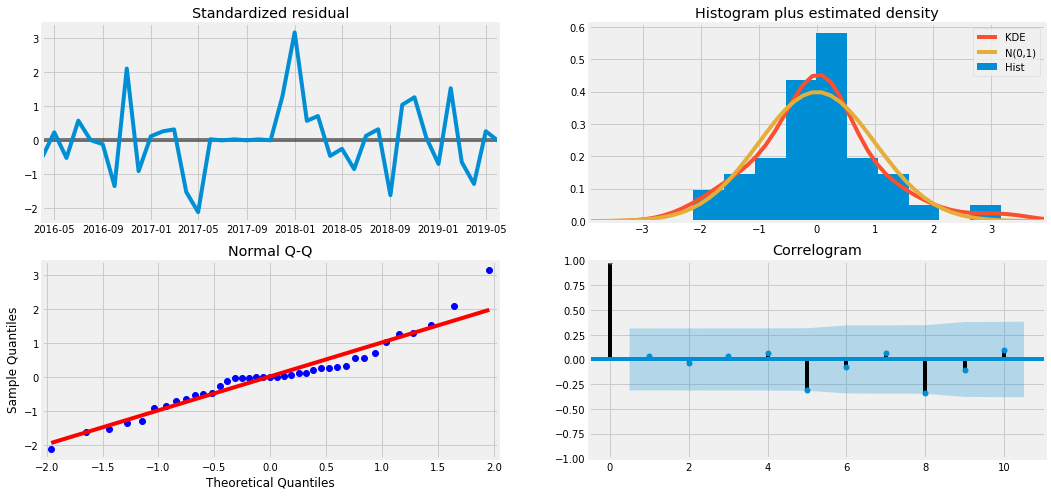

In [77]:
results.plot_diagnostics(figsize=(16, 8))
plt.show();

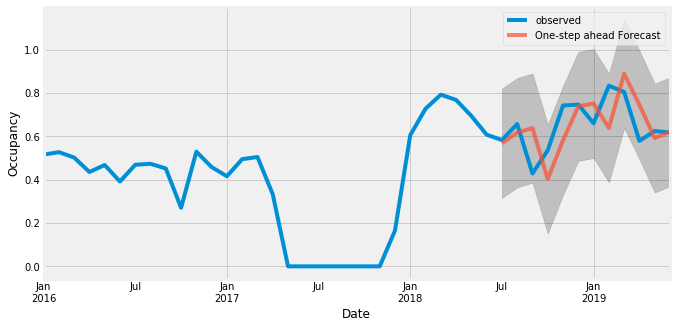

In [78]:
pred = results.get_prediction(start=pd.to_datetime('2018-07-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Occupancy')
plt.legend()
plt.show();

The ARIMA model forecasts align with the true values pretty well.

In [79]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-07-01':]

# Compute the RMSE
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of occupancy forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of occupancy forecasts is 0.12


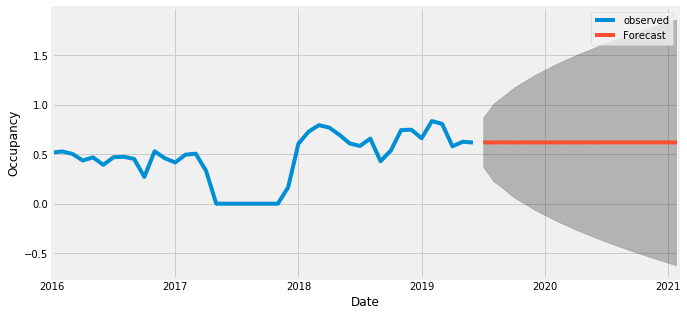

In [82]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(10, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Occupancy')
plt.legend()
plt.show();

ARIMA predictes a very flat future.

### Predicting and forecasting Occupancy with Prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 720x360 with 0 Axes>

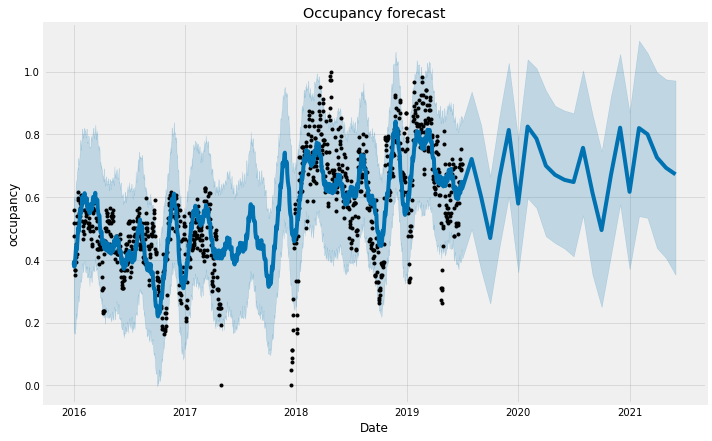

In [85]:
sbz.reset_index(inplace=True)
occ = sbz[['DATE', 'OCC %']]
occ = occ.rename(columns = {'DATE': 'ds', 'OCC %': 'y'})
occ['cap'] = 1.0
model = Prophet(interval_width=0.95)
# Remove the none values for the 6.5 months
occ.loc[(occ['ds'] > '2017-04-30') & (occ['ds'] < '2017-12-15'), 'y'] = None
model.fit(occ)
forecast = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(forecast)
plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'occupancy')
plt.title('Occupancy forecast');

In [86]:
metric_df = forecast.set_index('ds')[['yhat']].join(occ.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
mse = mean_squared_error(metric_df.y, metric_df.yhat)
print('The Root Mean Squared Error of occupancy forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of occupancy forecasts is 0.11


Prophet plots the observed values of our occupancy time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

As we can see Prophet catches the trends and most of the time gets values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series.

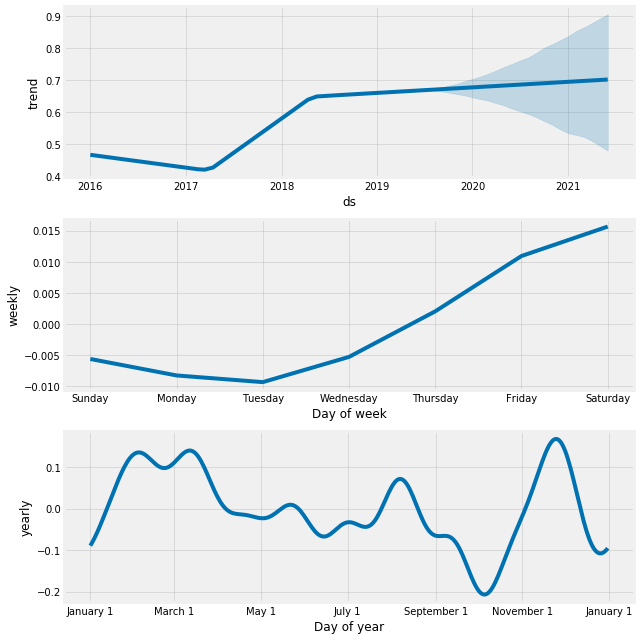

In [87]:
model.plot_components(forecast);

Observations:

* Prophet forecasts that the hotel occupancy will likely to be flat into the future years. This in align with ARIMA's prediction.
* Prophet reveals that Tuesdays are the lowest day-of-week in occupancy, and Saturdays are the highest day-of-week in occupancy.
* Prophet reveals that the worst month in occupancy is around October and the best months in occupancy are around the end of the year.

Summary:

* I believe there is a very strong seasonaity in this hotel's business.
* This hotel seems to be affected by the hurricane season.
* The hotel occupany, revenue and average daily rate started to grow rapidly since January 2018, immediately after 7 months closure, and business has been steady for the past several months.
* I believe when fully operational, the hotel should follow the similar trend year over year.
* Around September and October are the worst months of the year, in terms of occupancy and revenue.
* The best months of the year are around February and March and March, in terms of occupany. 
* The best months of the year are around January in terms of revenue and average daily rate.
* The hotel achieved its highest revenue and average daily rate around January 2019. 
* Both models predict the future will be flat in general. In this case, I would like to trust Prophet more because I think Prophet deals with outliers better.